In [1]:

!git clone https://github.com/kelvis24/simple-3d-objects.git

!git clone https://github.com/kelvis24/pointclouds.git

!pip install torch

!pip install plyfile

!pip install matplotlib

!pip install open3d

Cloning into 'simple-3d-objects'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 23 (delta 4), reused 6 (delta 1), pack-reused 0
Receiving objects: 100% (23/23), 8.33 MiB | 13.67 MiB/s, done.
Resolving deltas: 100% (4/4), done.
Cloning into 'pointclouds'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 13 (delta 2), reused 12 (delta 1), pack-reused 0
Receiving objects: 100% (13/13), 7.94 MiB | 11.46 MiB/s, done.
Resolving deltas: 100% (2/2), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.7/399.7 MB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 49.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 83.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

In [2]:


import numpy as np
import torch
from plyfile import PlyData
import os

# Custom function to load point cloud data from binary .ply files
def load_point_cloud_from_ply(file_path):
    ply_data = PlyData.read(file_path)
    x = ply_data['vertex']['x']
    y = ply_data['vertex']['y']
    z = ply_data['vertex']['z']
    points = torch.tensor(np.column_stack((x, y, z)), dtype=torch.float32)
    return points

def resample_point_cloud(point_cloud, num_points):
    if len(point_cloud) == num_points:
        return point_cloud
    elif len(point_cloud) > num_points:
        indices = np.random.choice(len(point_cloud), size=num_points, replace=False)
        return point_cloud[indices]
    else:
        raise ValueError("Point cloud needs more points for resampling.")


In [3]:
# Load all point clouds from the directory
point_clouds_directory = '/content/simple-3d-objects'
point_cloud_files = [f for f in os.listdir(point_clouds_directory) if f.endswith('.ply')]
point_clouds = [load_point_cloud_from_ply(os.path.join(point_clouds_directory, f)) for f in point_cloud_files]

# Find the number of points in the smallest point cloud
min_points = min(pc.shape[0] for pc in point_clouds)

# Resample all point clouds to match the smallest one
point_clouds = [resample_point_cloud(pc, min_points) for pc in point_clouds]


In [4]:
point_clouds = point_clouds[:6]

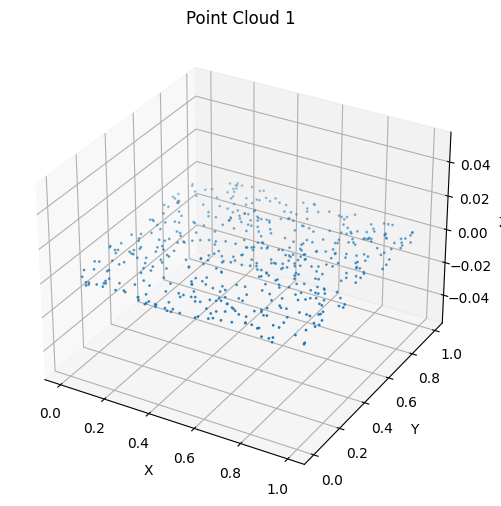

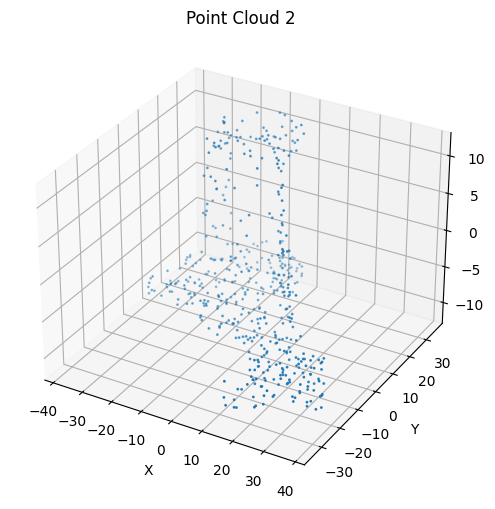

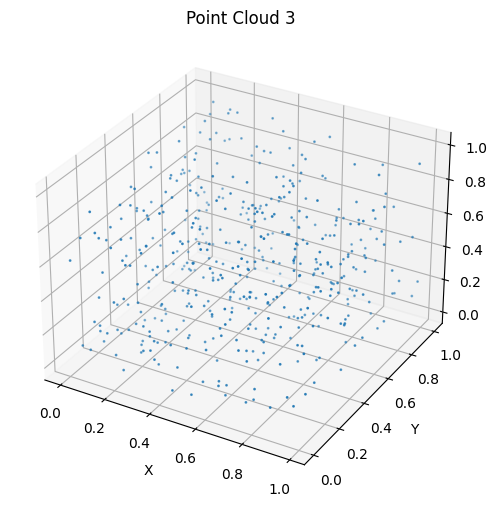

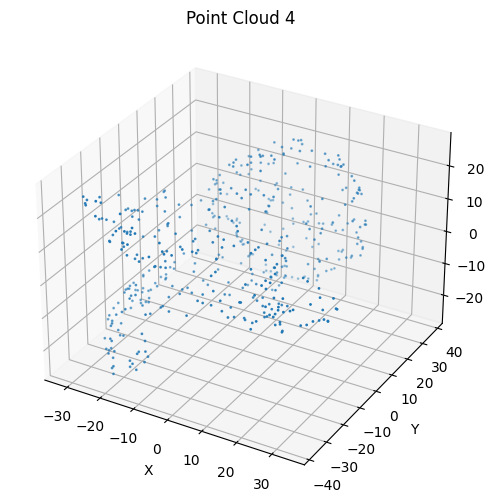

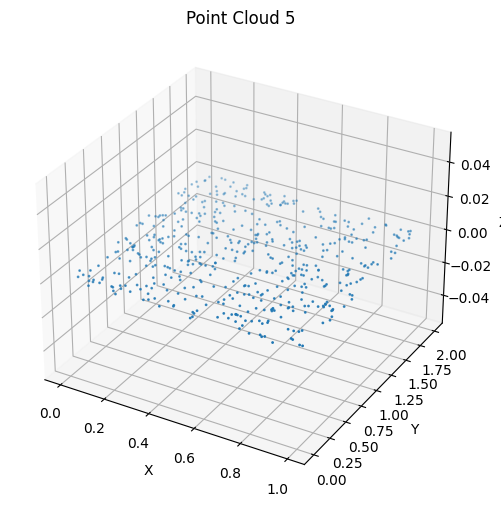

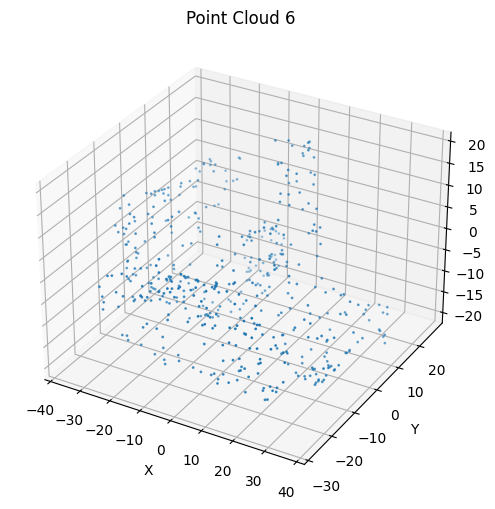

In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Function to plot a single point cloud
def plot_point_cloud(points, title="Point Cloud", ax=None):
    if ax is None:
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection='3d')
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=1)  # 's' is the size of each point
    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    return ax

# Assuming 'sorted_point_clouds' is a list of numpy arrays representing your sorted point clouds
for i, point_cloud in enumerate(point_clouds):
    plot_point_cloud(point_cloud, title=f"Point Cloud {i + 1}")
    plt.show()

# Convert to a single tensor
point_clouds_tensor = torch.stack(point_clouds)

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim

class Autoencoder(nn.Module):
    def __init__(self, input_size, encoding_dim):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Dropout(0.5),  # Adding dropout
            nn.Linear(128, encoding_dim)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.5),  # Adding dropout
            nn.Linear(128, input_size)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Set random seed for reproducibility
seed_value = 42
torch.manual_seed(seed_value)
np.random.seed(seed_value)

# Assuming Autoencoder is defined as previously

# Early stopping parameters
patience = 30  # Number of epochs to wait after min has been hit
min_delta = 0.001  # Minimum change to qualify as an improvement
best_loss = np.inf
epochs_no_improve = 0

# Parameters
input_size = point_clouds_tensor.shape[1] * point_clouds_tensor.shape[2]
encoding_dim = 5000  # Example encoding dimension

# Flatten point clouds for processing
flat_point_clouds = point_clouds_tensor.view(point_clouds_tensor.shape[0], -1)

# Initialize the autoencoder
autoencoder = Autoencoder(input_size, encoding_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

# Training loop with early stopping
for epoch in range(10000):  # Number of epochs
    total_loss = 0
    for data in flat_point_clouds:
        encoded, decoded = autoencoder(data)
        loss = criterion(decoded, data)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(flat_point_clouds)
    print(f"Epoch {epoch}, Avg Loss: {avg_loss}")

    # Check for early stopping
    if best_loss - avg_loss > min_delta:
        best_loss = avg_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            print("Early stopping triggered")
            break

encoded_point_clouds = []
with torch.no_grad():
    for data in flat_point_clouds:
        encoded, _ = autoencoder(data)
        encoded_point_clouds.append(encoded)

encoded_point_clouds_tensor = torch.stack(encoded_point_clouds)

Epoch 0, Avg Loss: 139.3925435220202
Epoch 1, Avg Loss: 163.11161379267773
Epoch 2, Avg Loss: 146.1215953603387
Epoch 3, Avg Loss: 151.77920770645142
Epoch 4, Avg Loss: 146.46173208455244
Epoch 5, Avg Loss: 153.13996234784523
Epoch 6, Avg Loss: 146.52753828962645
Epoch 7, Avg Loss: 161.83535327017307
Epoch 8, Avg Loss: 691.3176109815637
Epoch 9, Avg Loss: 207.4346950451533
Epoch 10, Avg Loss: 190.799420495828
Epoch 11, Avg Loss: 199.8423579732577
Epoch 12, Avg Loss: 135.8718986560901
Epoch 13, Avg Loss: 270.4580888822675
Epoch 14, Avg Loss: 467.84637618561584
Epoch 15, Avg Loss: 154.92800679057837
Epoch 16, Avg Loss: 161.8082618738214
Epoch 17, Avg Loss: 139.1252076725165
Epoch 18, Avg Loss: 142.495550143222
Epoch 19, Avg Loss: 137.36044441660246
Epoch 20, Avg Loss: 144.52581709871689
Epoch 21, Avg Loss: 480.26156441618997
Epoch 22, Avg Loss: 137.0064059048891
Epoch 23, Avg Loss: 136.85327177743116
Epoch 24, Avg Loss: 138.43698225915432
Epoch 25, Avg Loss: 435.35961760083836
Epoch 26, 

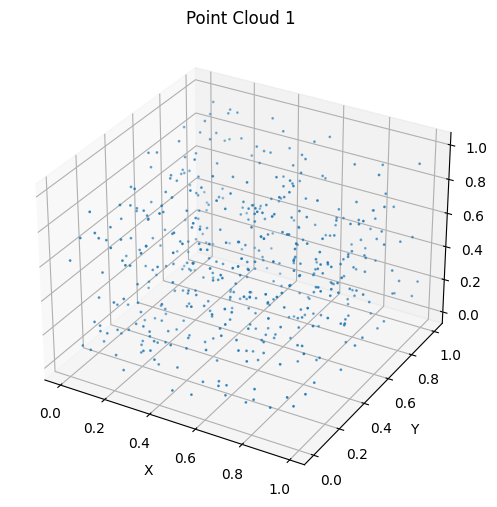

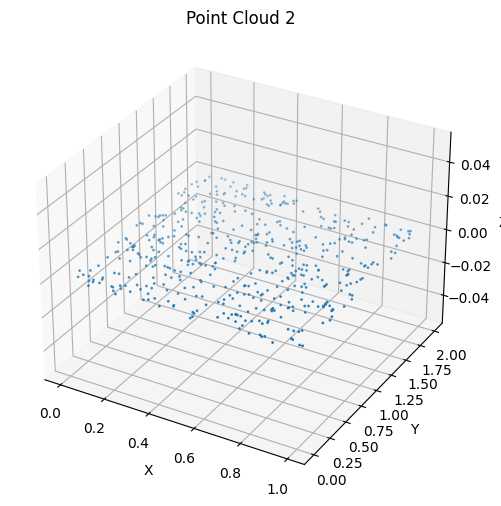

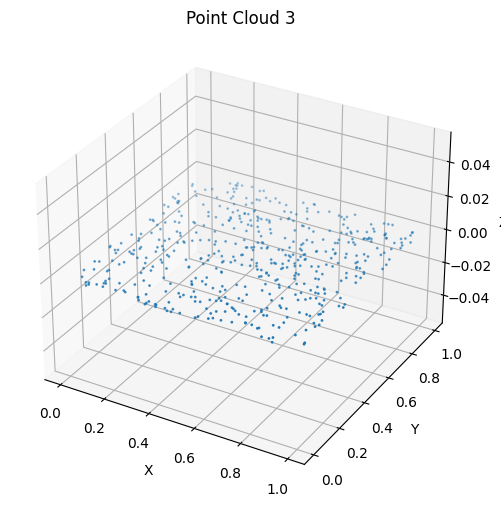

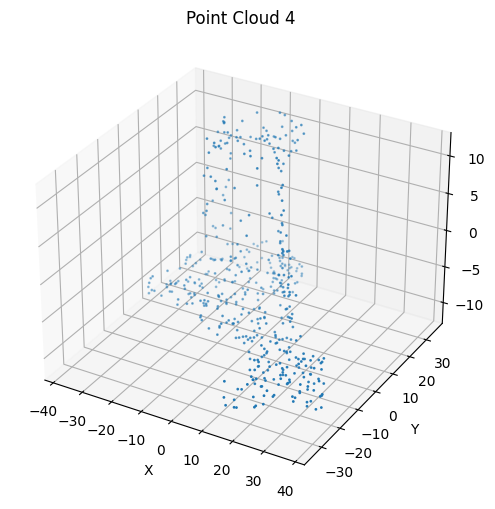

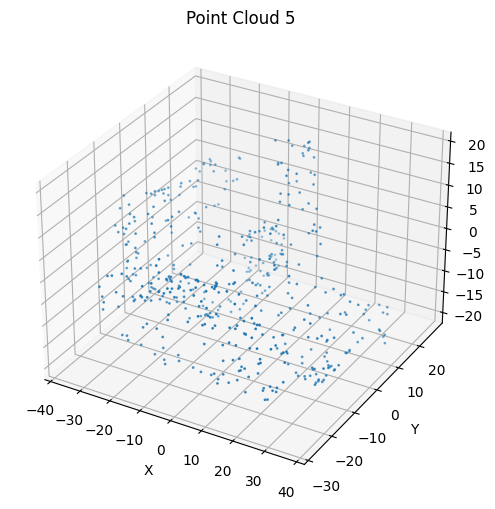

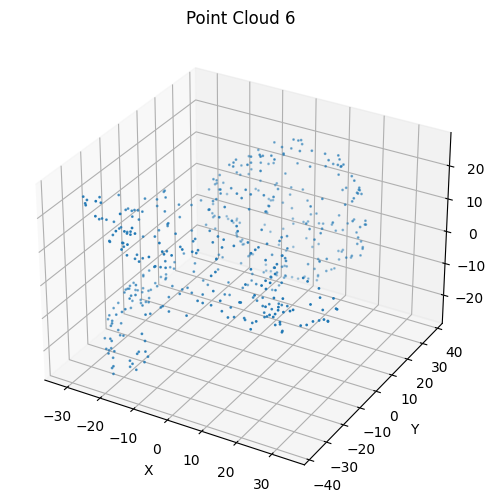

In [8]:
from scipy.spatial.distance import pdist, squareform

# Calculate pairwise distances between encoded representations
distances = pdist(encoded_point_clouds_tensor, 'euclidean')
distance_matrix = squareform(distances)

# Sort based on similarity (smaller distances)
sorted_indices = np.argsort(distance_matrix.sum(axis=0))
sorted_point_clouds = [point_clouds[i] for i in sorted_indices]

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Function to plot a single point cloud
def plot_point_cloud(points, title="Point Cloud", ax=None):
    if ax is None:
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection='3d')
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=1)  # 's' is the size of each point
    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    return ax

# Assuming 'sorted_point_clouds' is a list of numpy arrays representing your sorted point clouds
for i, point_cloud in enumerate(sorted_point_clouds):
    plot_point_cloud(point_cloud, title=f"Point Cloud {i + 1}")
    plt.show()


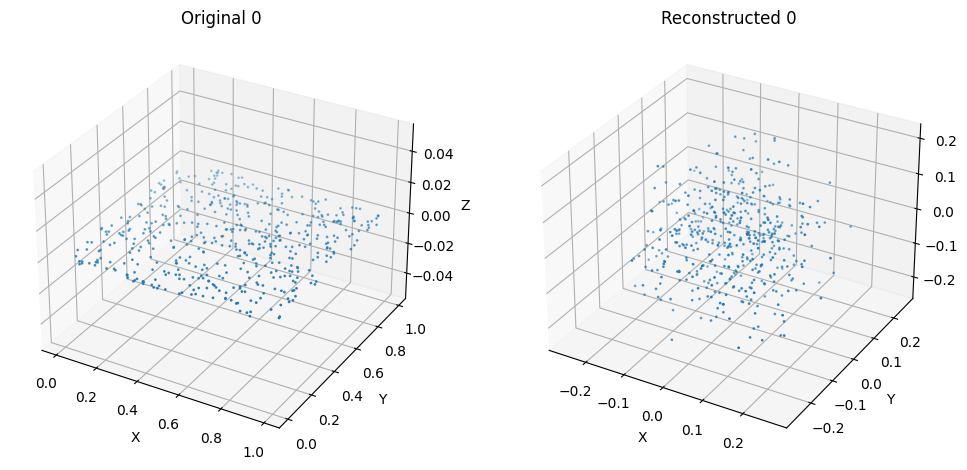

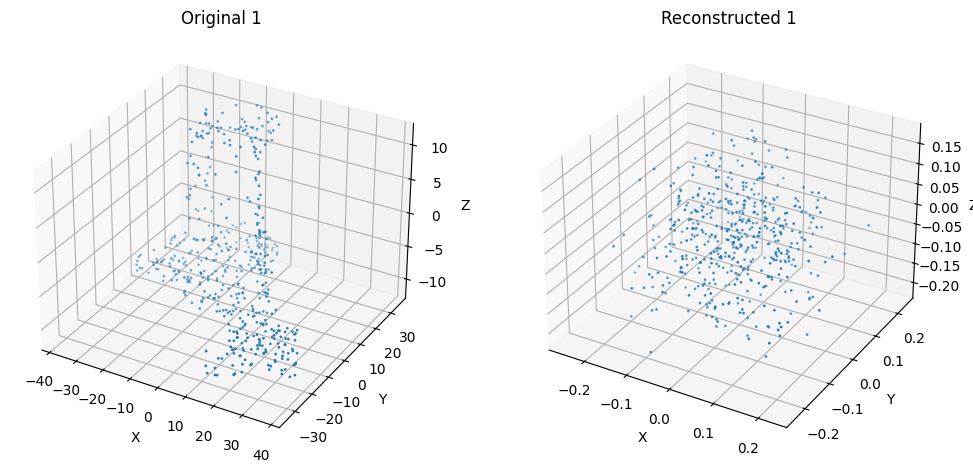

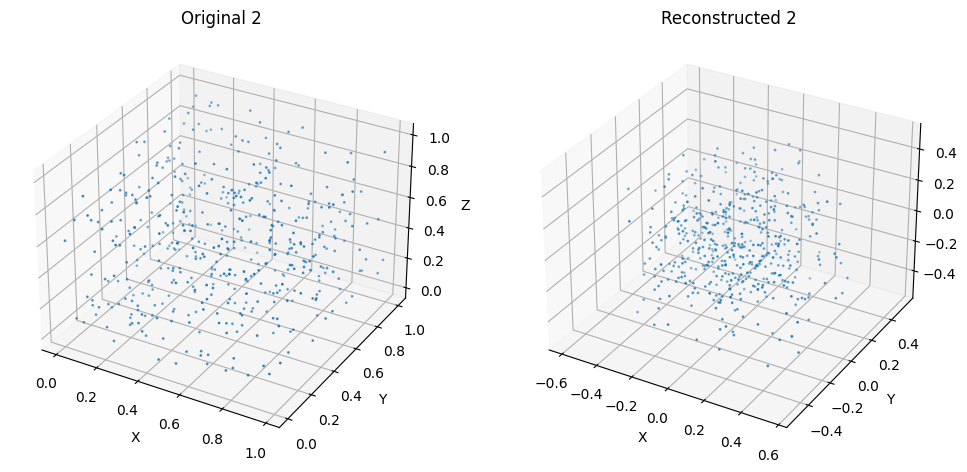

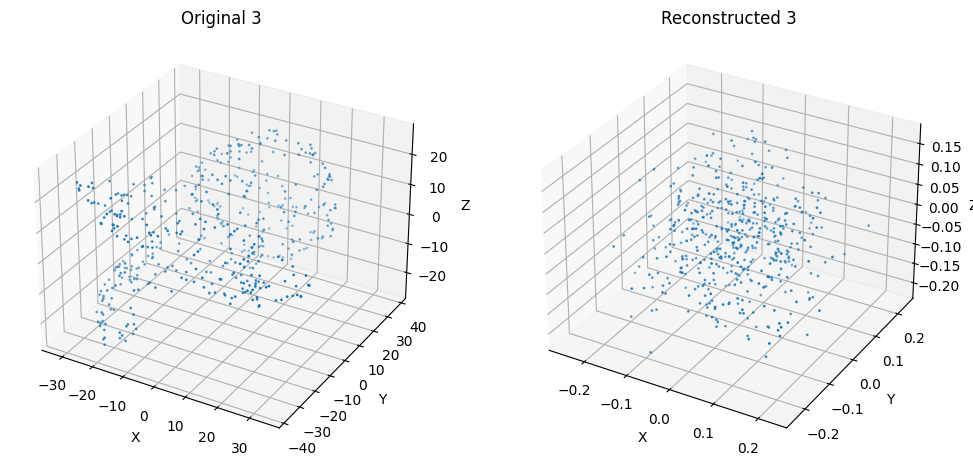

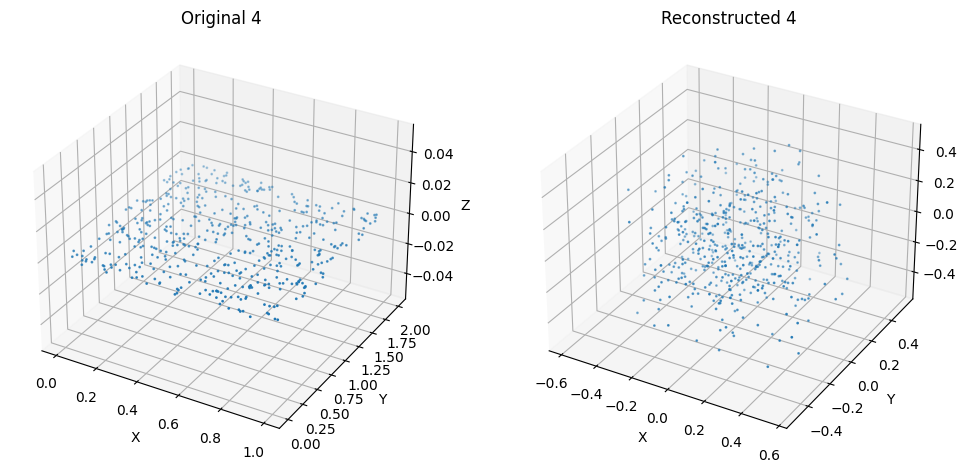

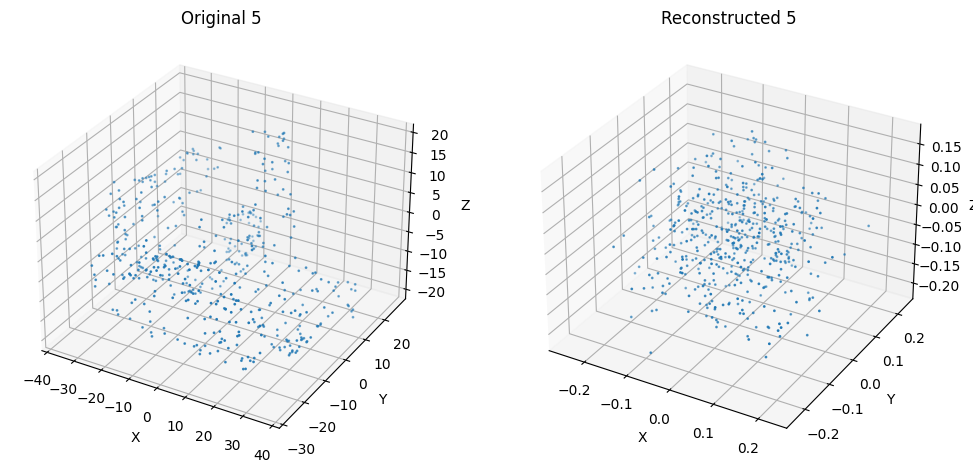

In [9]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_point_clouds(original, reconstructed, index, title1="Original", title2="Reconstructed"):
    fig = plt.figure(figsize=(12, 6))

    # Plot original point cloud
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.scatter(original[:, 0], original[:, 1], original[:, 2], s=1)
    ax1.set_title(f"{title1} {index}")
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')

    # Plot reconstructed point cloud
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.scatter(reconstructed[:, 0], reconstructed[:, 1], reconstructed[:, 2], s=1)
    ax2.set_title(f"{title2} {index}")
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_zlabel('Z')

    plt.show()


# Visualize all point clouds
with torch.no_grad():
    for i, sample_point_cloud in enumerate(flat_point_clouds):
        encoded, decoded = autoencoder(sample_point_cloud)
        decoded = decoded.view(-1, 3).numpy()  # Reshaping to 3D coordinates
        original = sample_point_cloud.view(-1, 3).numpy()  # Reshaping to 3D coordinates

        # Visualize
        plot_point_clouds(original, decoded, i)

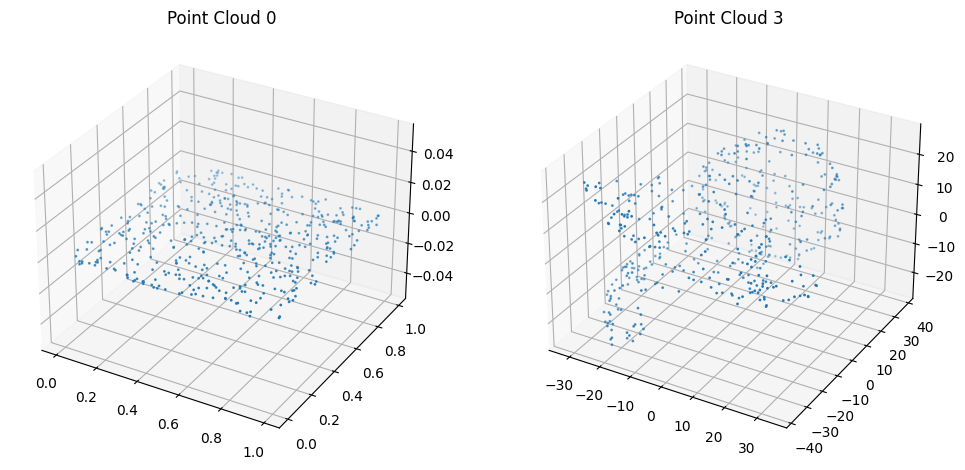

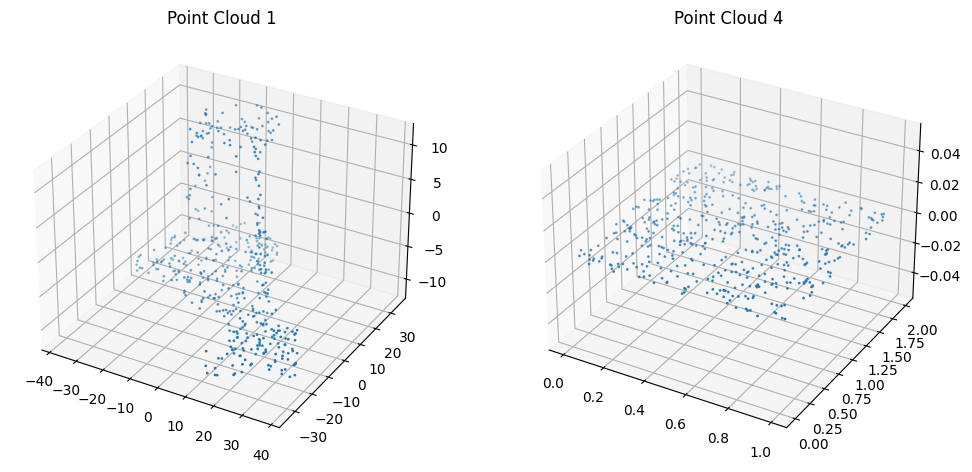

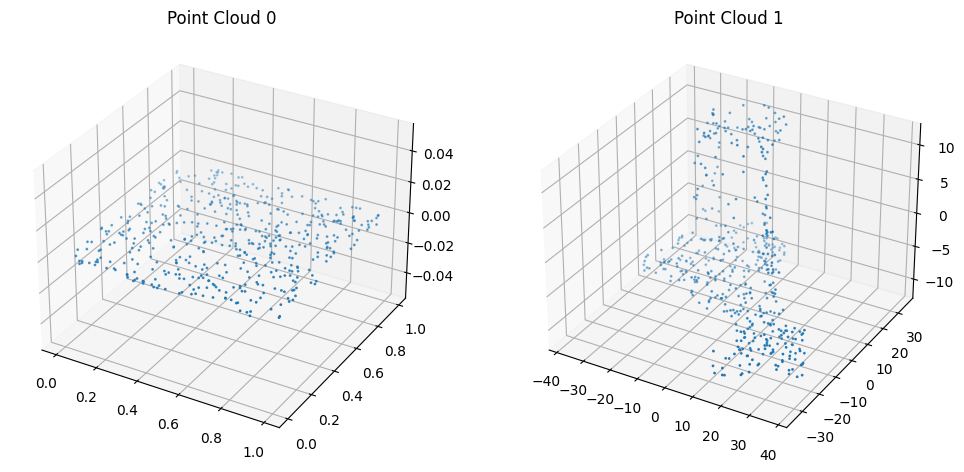

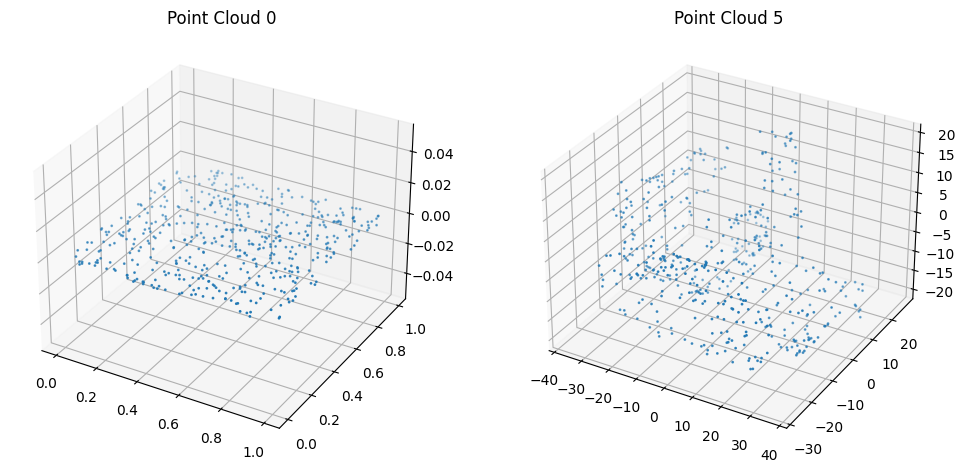

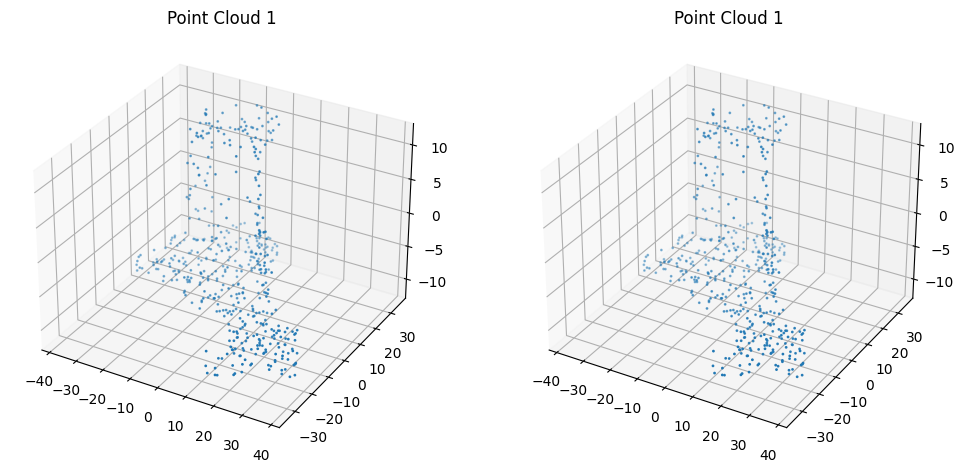

In [10]:
"""Plot similar point clouds next to each other for further reassurance"""

import numpy as np

def plot_point_clouds_side_by_side(pc1, pc2, title1="Point Cloud 1", title2="Point Cloud 2"):
    fig = plt.figure(figsize=(12, 6))

    # Plotting first point cloud
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.scatter(pc1[:, 0], pc1[:, 1], pc1[:, 2], s=1)
    ax1.set_title(title1)

    # Plotting second point cloud
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.scatter(pc2[:, 0], pc2[:, 1], pc2[:, 2], s=1)
    ax2.set_title(title2)

    plt.show()

# Find the indices of the closest pairs
num_pairs_to_visualize = 5  # Number of pairs you want to visualize
closest_pairs_indices = np.unravel_index(np.argsort(distances)[:num_pairs_to_visualize], distance_matrix.shape)

# Visualize each pair
for i in range(num_pairs_to_visualize):
    idx1, idx2 = closest_pairs_indices[0][i], closest_pairs_indices[1][i]
    pc1 = point_clouds[idx1].numpy()  # Assuming point_clouds is a tensor
    pc2 = point_clouds[idx2].numpy()  # Convert to numpy if required
    plot_point_clouds_side_by_side(pc1, pc2, f"Point Cloud {idx1}", f"Point Cloud {idx2}")

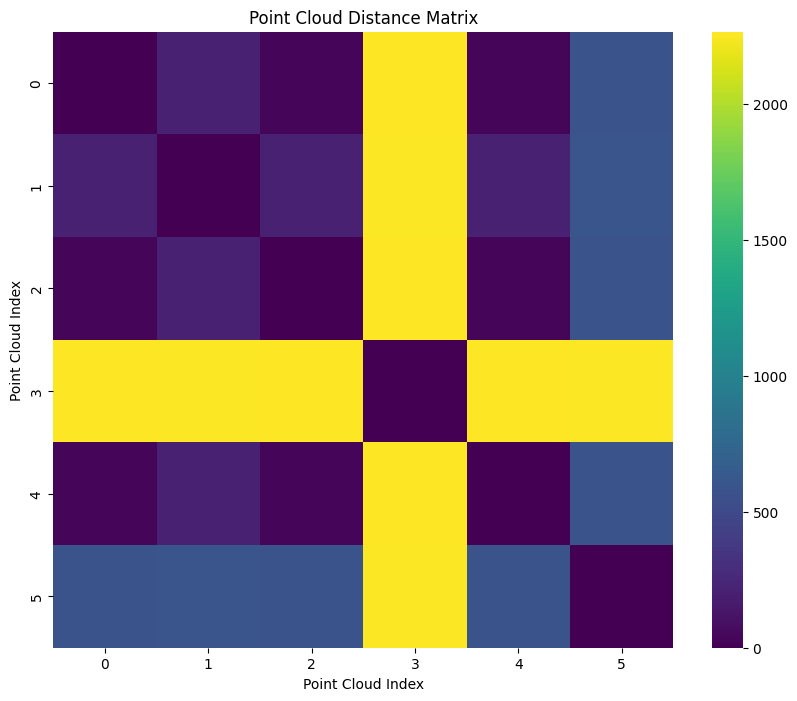

In [11]:
"""Using Heat maps"""

import seaborn as sns
import matplotlib.pyplot as plt

# Calculate pairwise distances between encoded representations
distances = pdist(encoded_point_clouds_tensor, 'euclidean')
distance_matrix = squareform(distances)

# Plotting the distance matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(distance_matrix, cmap='viridis')
plt.title("Point Cloud Distance Matrix")
plt.xlabel("Point Cloud Index")
plt.ylabel("Point Cloud Index")
plt.show()


****Interpolation****

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim

class InterpolationNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(InterpolationNet, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.layer3 = nn.Linear(hidden_size, output_size)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.layer1(x))
        x = self.activation(self.layer2(x))
        x = self.layer3(x)
        return x

In [13]:
point_clouds = sorted_point_clouds

In [14]:
print(len(point_clouds))

6


In [15]:
# Network parameters
input_size = 1
hidden_size = 128
output_size = point_clouds[0].shape[1] * min_points

# Initialize the network
net = InterpolationNet(input_size, hidden_size, output_size)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
epochs = 5000

# Training loop
num_point_clouds = len(point_clouds)
for epoch in range(epochs):
    for t in torch.linspace(0, num_point_clouds - 1, steps=50):
        # Identify the two point clouds to interpolate between
        lower_index = int(t)
        upper_index = min(lower_index + 1, num_point_clouds - 1)
        t_weight = t - lower_index

        # Forward pass
        net_output = net(t.view(1, -1))
        reshaped_output = net_output.view_as(point_clouds[0])

        # Compute target point cloud based on t
        target = (1 - t_weight) * point_clouds[lower_index] + t_weight * point_clouds[upper_index]

        # Compute loss
        loss = criterion(reshaped_output, target)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch [{epoch}/{epochs}], Loss: {loss.item()}")


Epoch [0/5000], Loss: 328.8171081542969
Epoch [100/5000], Loss: 1.0213655233383179
Epoch [200/5000], Loss: 1.8892849683761597
Epoch [300/5000], Loss: 0.7202450633049011
Epoch [400/5000], Loss: 0.8365026712417603
Epoch [500/5000], Loss: 0.5488807559013367
Epoch [600/5000], Loss: 0.7945383191108704
Epoch [700/5000], Loss: 3.2012155055999756
Epoch [800/5000], Loss: 0.13988180458545685
Epoch [900/5000], Loss: 0.04758826270699501
Epoch [1000/5000], Loss: 1.4825706481933594
Epoch [1100/5000], Loss: 2.6723432540893555
Epoch [1200/5000], Loss: 0.7936539053916931
Epoch [1300/5000], Loss: 1.4435944557189941
Epoch [1400/5000], Loss: 0.47897547483444214
Epoch [1500/5000], Loss: 0.745154619216919
Epoch [1600/5000], Loss: 1.5027738809585571
Epoch [1700/5000], Loss: 0.10778212547302246
Epoch [1800/5000], Loss: 0.6312916874885559
Epoch [1900/5000], Loss: 0.22731953859329224
Epoch [2000/5000], Loss: 0.16334837675094604
Epoch [2100/5000], Loss: 1.0059694051742554
Epoch [2200/5000], Loss: 1.2363336086273

In [16]:
def plot_point_cloud(ax, points):
    ax.scatter(points[:, 0], points[:, 1], points[:, 2])
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")


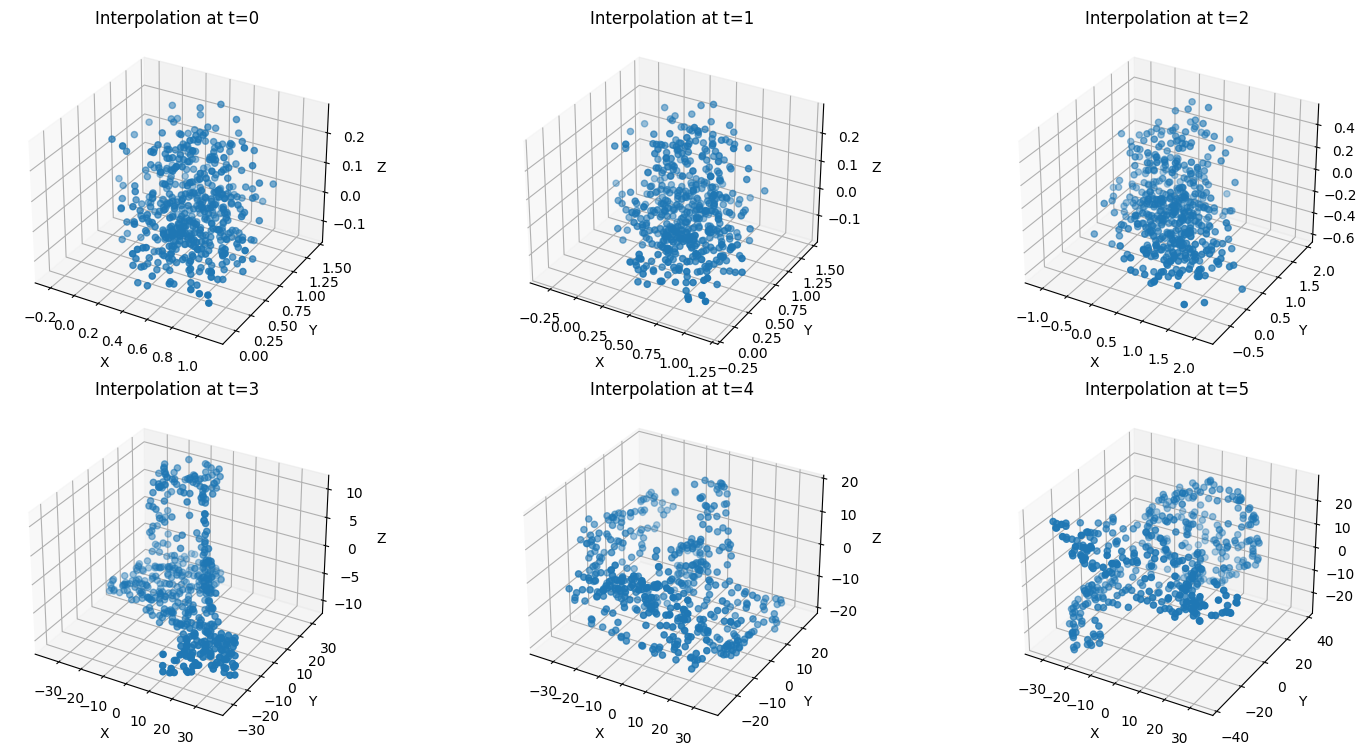

In [23]:
# Create subplots with a 4x3 grid (adjust the grid based on your preferences)
num_rows = 4
num_cols = 3
fig = plt.figure(figsize=(15, 15))
t_values = list(range(6))  # Assuming t values 0 to 11

for i, t in enumerate(t_values, 1):
    # Generate output from the neural network
    t_tensor = torch.tensor([t], dtype=torch.float32)
    output = net(t_tensor.view(1, -1))
    output = output.view_as(point_clouds[0]).detach().numpy()

    # Create subplot in a 4x3 grid
    ax = fig.add_subplot(num_rows, num_cols, i, projection='3d')
    plot_point_cloud(ax, output)
    ax.set_title(f"Interpolation at t={t}")

plt.tight_layout()
plt.show()


***Find Optimal T Value***

In [49]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from plyfile import PlyData
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Function to find the optimal t value for a new point cloud
def find_optimal_t(new_point_cloud, net, min_t=0, max_t=11, num_steps=10000):
    new_point_cloud = resample_point_cloud(new_point_cloud, 500)
    t_values = torch.linspace(min_t, max_t, steps=num_steps)
    min_loss = float('inf')
    optimal_t = None

    with torch.no_grad():
        for t in t_values:
            # Forward pass
            net_output = net(t.view(1, -1))
            reshaped_output = net_output.view_as(point_clouds[0])

            # Compute loss
            loss = criterion(reshaped_output, new_point_cloud)

            if loss < min_loss:
                min_loss = loss.item()
                optimal_t = t.item()

    return optimal_t

In [50]:
def visualize_new_point_cloud(new_point_cloud_path, net, point_clouds, num_rows=1, num_cols=2, figsize=(16, 8)):
    # Load a new point cloud
    new_point_cloud = load_point_cloud_from_ply(new_point_cloud_path)

    # Find the optimal t value for the new point cloud
    optimal_t = find_optimal_t(new_point_cloud, net)
    print(f"Optimal t value for new point cloud: {optimal_t}")

    # Visualize the new point cloud at the optimal t
    fig = plt.figure(figsize=figsize)

    # Plot the new point cloud
    ax1 = fig.add_subplot(num_rows, num_cols, 1, projection='3d')
    plot_point_cloud(ax1, new_point_cloud)
    ax1.set_title("New Point Cloud")

    # Plot the new point cloud at the optimal t
    t_tensor = torch.tensor([optimal_t], dtype=torch.float32)
    optimal_output = net(t_tensor.view(1, -1))
    optimal_output = optimal_output.view_as(point_clouds[0]).detach().numpy()

    ax2 = fig.add_subplot(num_rows, num_cols, 2, projection='3d')
    plot_point_cloud(ax2, optimal_output)
    ax2.set_title(f"Optimal Point Cloud at t={optimal_t}")

    plt.show()

Optimal t value for new point cloud: 0.0


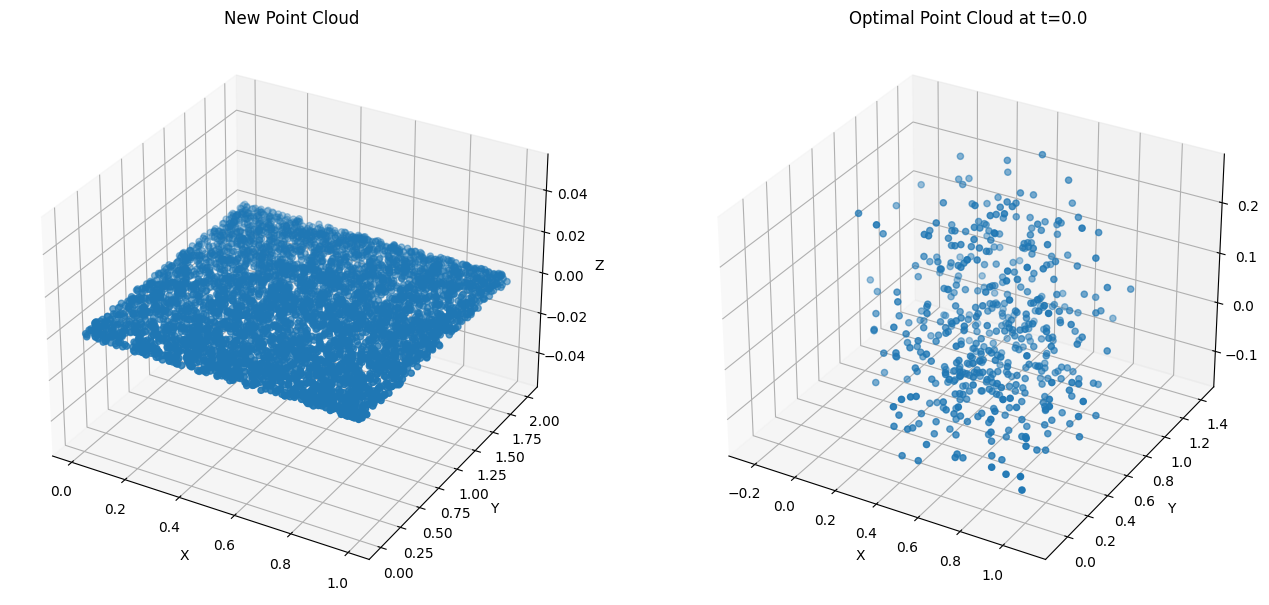

CORRECT


In [51]:
# Example usage
new_point_cloud_path = '/content/simple-3d-objects/rectangle.ply'
visualize_new_point_cloud(new_point_cloud_path, net, point_clouds)
print("CORRECT")


Optimal t value for new point cloud: 2.062706232070923


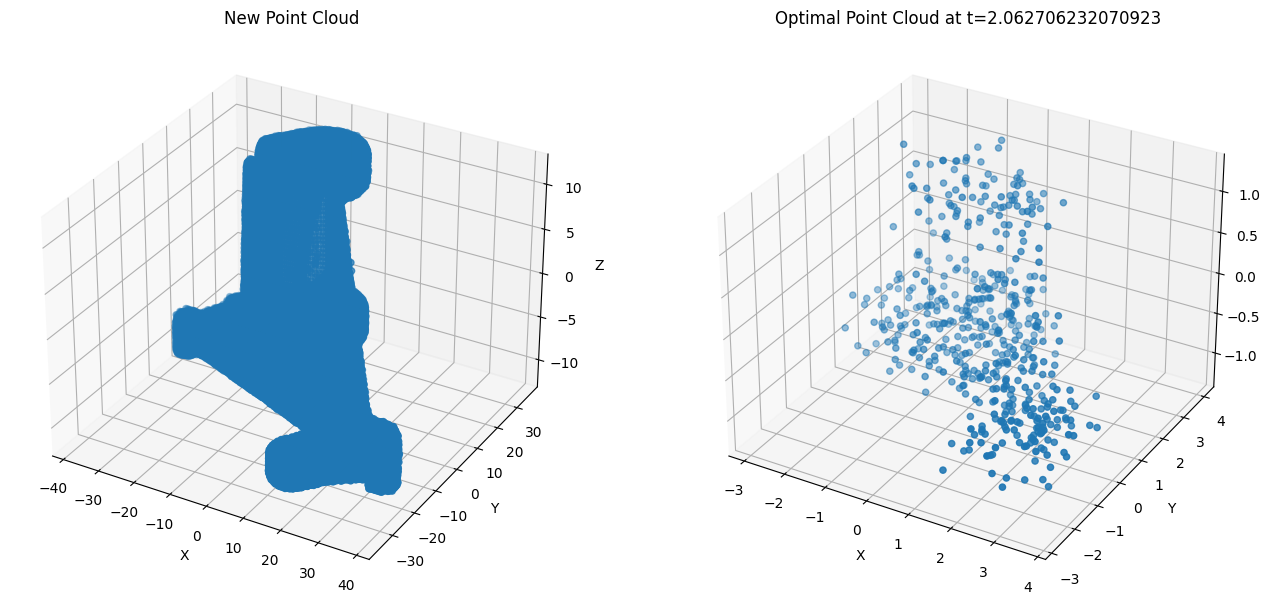

CORRECT


In [52]:
# Example usage
new_point_cloud_path = '/content/simple-3d-objects/daratech.ply'
visualize_new_point_cloud(new_point_cloud_path, net, point_clouds)
print("CORRECT")


Optimal t value for new point cloud: 0.0


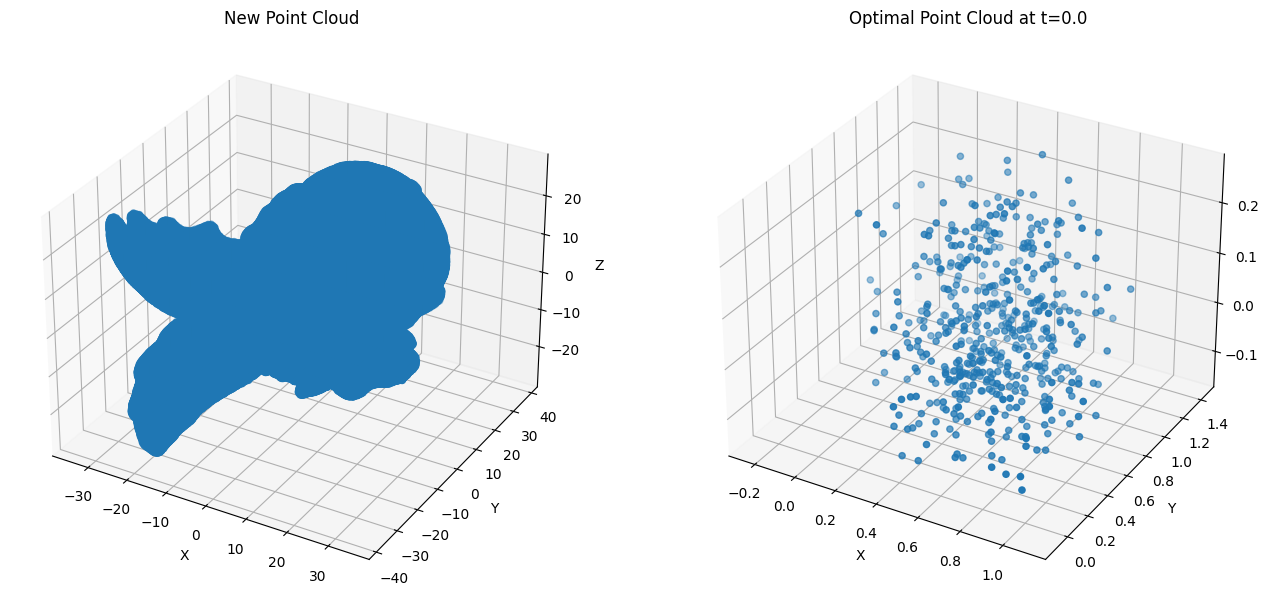

FALSE


In [53]:
# Example usage
new_point_cloud_path = '/content/simple-3d-objects/gargoyle.ply'
visualize_new_point_cloud(new_point_cloud_path, net, point_clouds)
print("FALSE")

In [54]:
# Load a new point cloud (replace 'new_point_cloud_path' with the actual path)
new_point_cloud_path = '/content/simple-3d-objects/gargoyle.ply'
new_point_cloud = load_point_cloud_from_ply(new_point_cloud_path)

In [55]:
for i in range(10):
    # Find the optimal t value for the new point cloud
    optimal_t = find_optimal_t(new_point_cloud, net)
    print(f"Optimal t value for new point cloud: {optimal_t}")
print("FIX INCONSISTENCY")


Optimal t value for new point cloud: 0.0
Optimal t value for new point cloud: 0.0
Optimal t value for new point cloud: 1.8448845148086548
Optimal t value for new point cloud: 0.0
Optimal t value for new point cloud: 0.0
Optimal t value for new point cloud: 1.9251924753189087
Optimal t value for new point cloud: 0.0
Optimal t value for new point cloud: 0.0
Optimal t value for new point cloud: 0.0
Optimal t value for new point cloud: 1.7348735332489014
FIX INCONSISTENCY
